# 0. Introdução
O modelo e a análise feita abaixo foi utilizando os dados transacionais de um banco fictício disponíveis em: https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view

Nossa motivação e objetio é criar um modelo classificador para indicar e poder prever quando uma transação e fraudulenta ou não. Utilizaremos de entendimento dos dados, análise exploratória, transformação das variáveis, criação do modelo, validação do resultado e deploy do modelo.


# 1. Entendimento dos Dados
# 1.1 Carregando as bibliotecas

In [1]:
!pip install imblearn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns



import warnings 
warnings.filterwarnings("ignore")

# 1.2 Carregando o Dataset
Nosso objetivo agora vai ser fazer uma análise inicial para entender como os dados estão disponibilizados.

In [3]:
dataset = pd.read_csv("fraud_detection.csv")

In [4]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
dataset.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [6]:
dataset.shape

(6362620, 11)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


dataset.isnull().sum()

In [8]:
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Após realizar uma primeira observação podemos notar que contamos 11 colunas sendo todas variáveis, e que conta com 6362620 linhas disponíveis de transações passadas.

Notamos também que contamos com 3 variáveis qualitativas e 8 variáveis quantitativas. Podemos ver que não contamos com nenhum valor nulo, em branco ou faltante.

# 1.3 Análise Exploratória

Agora irei realizar uma análise exploratória unidimensional para algumas das variáveis e análise bidimensional para olhar a correlação de pearson para todas variáveis.

In [9]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

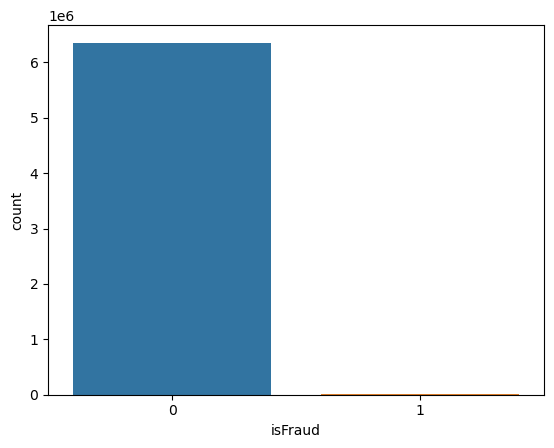

In [10]:
sns.countplot(data= dataset, x="isFraud")
plt.show()

Obtemos o primeiro insight que é que nossa variável conta apenas com 8213 valores que são fraudes.

<AxesSubplot:xlabel='type', ylabel='count'>

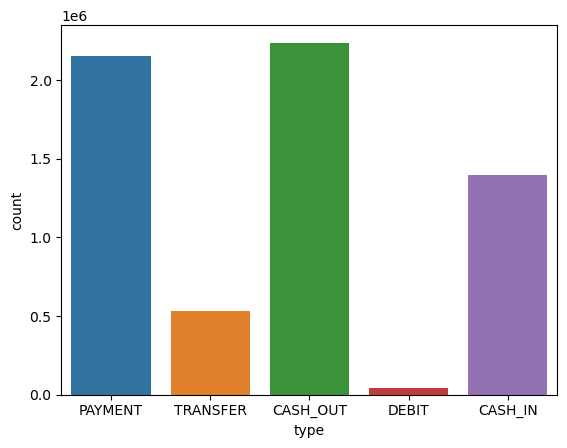

In [11]:
sns.countplot(data=dataset, x="type")

In [12]:
dataset[dataset["isFraud"] == 1]["type"].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

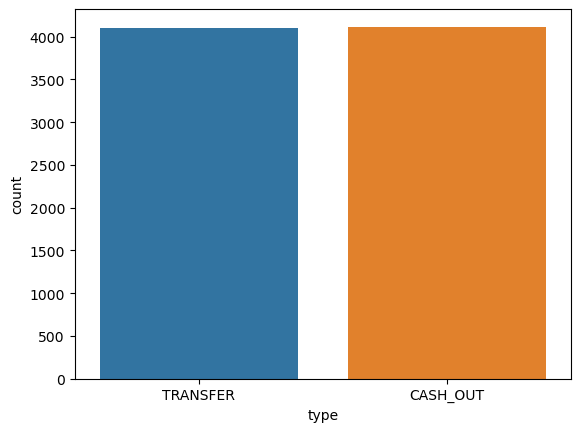

In [13]:
sns.countplot(dataset[dataset["isFraud"] == 1]["type"])
plt.show()

Obtemos outro insight que quando a transação é flagrada como fraude, temos apenas dois tipos de pagamento dos cinco disponíveis. Transferência e Saque.

<AxesSubplot:>

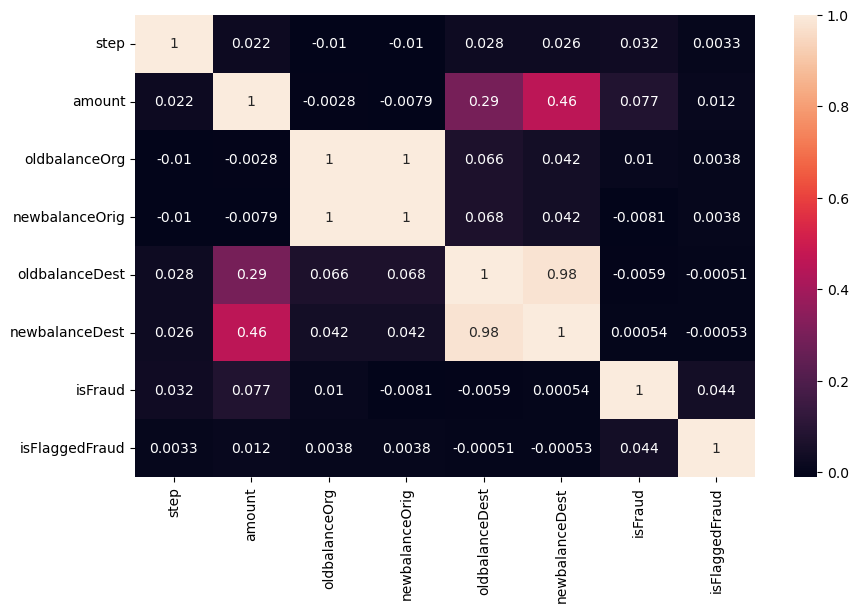

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(), annot=True)

# 2. Transformação dos Dados
A coluna step representa o total de horas que decorreu desde o ínicio da coleta dos dados, ela varia entr 1 e 743 o que representa 30 dias, vamos transforma-la em horas para obter uma melhor resultado do modelo

In [15]:
dataset_copy = dataset.copy()

In [16]:
dates = dataset["step"].unique()

In [17]:
dates

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [18]:
hours = []
num = 0
for _ in range(0,743):
    hours.append(num)
    num += 1
    if num % 24 == 0:
        num = 0

In [19]:
hours

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2

Criamos outro Dataframe que representa cada hora em relação ao step para assim poder juntar ao dataframe original.

In [20]:
df_hours = pd.DataFrame({"step": dates})
df_hours["hours"] = hours

In [21]:
df_hours

,step,hours
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
738,739,18
739,740,19
740,741,20
741,742,21


In [22]:
dataset_hours = pd.merge(dataset_copy, df_hours, on=['step'], how='left')

In [23]:
dataset_hours

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hours
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,22
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,22
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,22
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,22


<AxesSubplot:xlabel='hours', ylabel='count'>

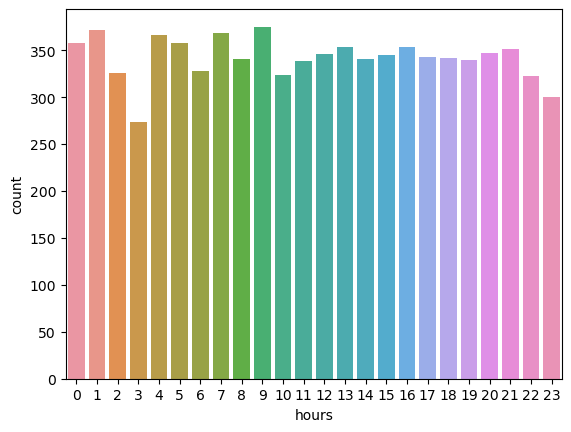

In [24]:
sns.countplot(dataset_hours[dataset_copy['isFraud'] == 1]['hours'])

Podemos ver que ocorre um número parecido de transações para cada hora do dia, porém vamos separar apenas as transações fraudulentas e ver o que obtemos.

In [25]:
p1 = dataset_hours.groupby('hours')['isFraud'].count()

In [26]:
p2 = dataset_hours.groupby('hours')['isFraud'].sum()

In [27]:
percentage_frauds = round(p2/p1, 2)

In [28]:
percentage_frauds

hours
0     0.01
1     0.04
2     0.16
3     0.22
4     0.22
5     0.10
6     0.04
7     0.01
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
13    0.00
14    0.00
15    0.00
16    0.00
17    0.00
18    0.00
19    0.00
20    0.00
21    0.00
22    0.00
23    0.00
Name: isFraud, dtype: float64

<AxesSubplot:xlabel='hours'>

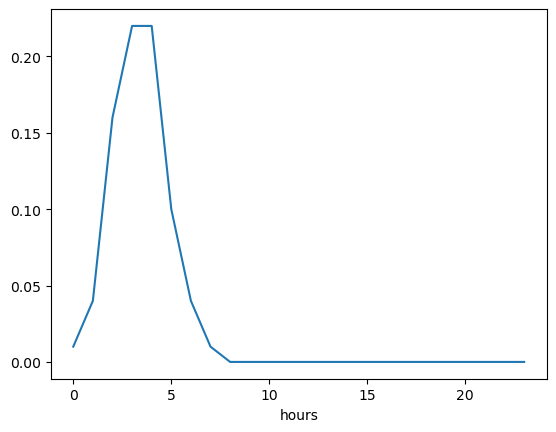

In [29]:
percentage_frauds.plot()

Dado esses resultados, as horas da madrugada são onde tem maior frequência de ocorrência de fraudes então para criar nosso modelo, iremos classificar elas como 1 para representar que é um horário mais "perigoso".

In [30]:
class_hours = pd.DataFrame({'hours': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                   'hour_class': [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]})

In [31]:
df_features = pd.merge(dataset_hours, class_hours, on=["hours"], how='left')

In [32]:
df_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hours,hour_class
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,22,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,22,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,22,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,22,0


Agora faremos a junção das contas "nameDest" e "nameOrig" afim de obter a quantidade de transações de cada conta o que também pode ser um indício de fraude.

In [33]:

transf = pd.DataFrame({"nameDest": df_features['nameDest'].value_counts().index,
    'quanTransf': df_features['nameDest'].value_counts()})


In [34]:
df_final_features = pd.merge(df_features, transf, on=['nameDest'], how='left')

In [35]:
df_final_features = df_final_features.drop(['step', 'nameOrig', 'nameDest', 'newbalanceDest', 'hours'], axis=1)

In [36]:
df_final_features

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFraud,isFlaggedFraud,hour_class,quanTransf
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0,0,1,1
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0,0,1,1
2,TRANSFER,181.00,181.00,0.00,0.00,1,0,1,44
3,CASH_OUT,181.00,181.00,0.00,21182.00,1,0,1,41
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0,0,1,1
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,1,0,0,2
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,1,0,0,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,1,0,0,3
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,1,0,0,1


Também iremos transformar a coluna type que representa o tipo de transação para uma variável quantitativa pois o modelo não trabalha com valores categóricos, como não existe uma ordem iremos botar os valores disponíveis de 0 a 4.

In [37]:
df_final_features['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [38]:
df_final_features['type'] = df_final_features['type'].map({'PAYMENT': 0.0, 'TRANSFER': 1.0, 'CASH_OUT': 2.0, 'DEBIT': 3.0, 'CASH_IN': 4.0})

In [39]:
df_final_features

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFraud,isFlaggedFraud,hour_class,quanTransf
0,0.0,9839.64,170136.00,160296.36,0.00,0,0,1,1
1,0.0,1864.28,21249.00,19384.72,0.00,0,0,1,1
2,1.0,181.00,181.00,0.00,0.00,1,0,1,44
3,2.0,181.00,181.00,0.00,21182.00,1,0,1,41
4,0.0,11668.14,41554.00,29885.86,0.00,0,0,1,1
...,...,...,...,...,...,...,...,...,...
6362615,2.0,339682.13,339682.13,0.00,0.00,1,0,0,2
6362616,1.0,6311409.28,6311409.28,0.00,0.00,1,0,0,1
6362617,2.0,6311409.28,6311409.28,0.00,68488.84,1,0,0,3
6362618,1.0,850002.52,850002.52,0.00,0.00,1,0,0,1


Assim Ficou o Dataset que iremos utilizar para criar o modelo
# 3. Criação do modelo
## 3.1 Carregando as bibliotecas

In [40]:
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



## 3.2 Separando os Valores
Aqui por conta de ter muitos dados disponíveis irei separar em 3 categorias, para melhor otimização, seriam elas a de treino, as válidas e a de teste

In [41]:
X = df_final_features.drop(['isFraud'], axis=1)
y = df_features['isFraud']

x_train, x_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=0)

x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=0)

In [42]:
x_train

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFlaggedFraud,hour_class,quanTransf
3019524,0.0,15595.97,0.00,0.00,0.00,0,0,1
1012167,0.0,7613.14,90120.00,82506.86,0.00,0,0,1
5551834,1.0,767351.67,0.00,0.00,4528365.13,0,0,6
2081309,2.0,167480.81,1293445.15,1125964.33,0.00,0,0,11
4457939,2.0,200937.21,104248.00,0.00,3242311.66,0,0,12
...,...,...,...,...,...,...,...,...
2249467,2.0,113691.83,4231.00,0.00,397758.64,0,0,10
5157699,2.0,3891.96,20146.00,16254.04,253375.00,0,0,8
2215104,4.0,79840.52,10152925.86,10232766.38,276175.87,0,0,6
1484405,4.0,568604.50,1081784.28,1650388.77,2631796.49,0,0,35


In [43]:
x_val

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFlaggedFraud,hour_class,quanTransf
1309516,2.0,427485.08,76871.00,0.00,0.00,0,0,14
1119267,0.0,1758.42,0.00,0.00,0.00,0,0,1
1240666,0.0,26730.13,0.00,0.00,0.00,0,0,1
5666402,2.0,173902.74,0.00,0.00,739121.45,0,0,7
1263423,0.0,78862.68,3242.00,0.00,0.00,0,0,1
...,...,...,...,...,...,...,...,...
1865815,2.0,68687.87,11089.00,0.00,29152.88,0,0,14
3556565,4.0,1040.88,3088601.48,3089642.36,2059822.72,0,0,19
1538259,2.0,110190.16,0.00,0.00,4507613.22,0,0,39
3201877,0.0,18758.77,149690.00,130931.23,0.00,0,0,1


In [44]:
x_test

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,isFlaggedFraud,hour_class,quanTransf
1789257,4.0,1546.17,15311803.29,15313349.47,252874.94,0,0,8
2098934,2.0,24210.42,0.00,0.00,962778.45,0,0,16
1068034,0.0,5499.19,5525.00,25.81,0.00,0,0,1
3319354,4.0,218660.44,459755.39,678415.83,391814.67,0,0,9
5010820,1.0,2391668.71,134293.00,0.00,0.00,0,0,2
...,...,...,...,...,...,...,...,...
4215048,2.0,479447.47,107981.00,0.00,0.00,0,0,4
3900579,0.0,24017.58,0.00,0.00,0.00,0,0,1
4865387,0.0,5183.60,0.00,0.00,0.00,0,0,1
4452781,1.0,677895.27,31465.00,0.00,0.00,0,0,3


In [45]:
x_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 3019524 to 4500015
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   type            4453834 non-null  float64
 1   amount          4453834 non-null  float64
 2   oldbalanceOrg   4453834 non-null  float64
 3   newbalanceOrig  4453834 non-null  float64
 4   oldbalanceDest  4453834 non-null  float64
 5   isFlaggedFraud  4453834 non-null  int64  
 6   hour_class      4453834 non-null  int64  
 7   quanTransf      4453834 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 305.8 MB


## 3.3 Modelo
Fazemos a criação do modelo utilizando os valores de treino e random_state=79 apenas para os valores não mudarem.

In [46]:
rfc = RandomForestClassifier(random_state=79)
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=79)

In [47]:
predv1 = rfc.predict(x_test)
print(classification_report(y_test, predv1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953199
           1       0.95      0.77      0.85      1194

    accuracy                           1.00    954393
   macro avg       0.98      0.88      0.93    954393
weighted avg       1.00      1.00      1.00    954393



<AxesSubplot:>

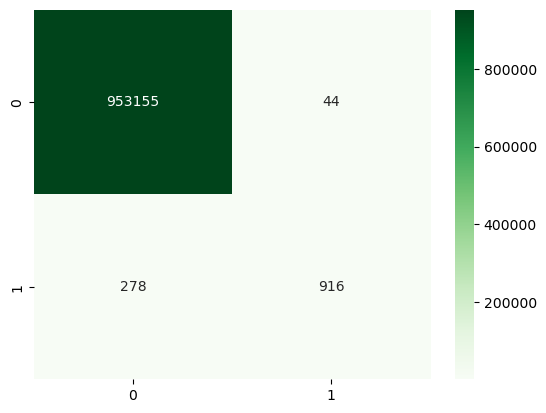

In [48]:
sns.heatmap(confusion_matrix(y_test, predv1), annot=True, fmt='d', cmap='Greens')

Observamos os valores do report da classificação, e vemos que o modelo classificou apenas 322 errados, porém vamos fazer a mesma coisa, porém otimizando o modelo com os melhores paramêtros (realizei alguns testes para chegar nesse resultado)

In [49]:
rfcfinal = RandomForestClassifier(max_depth=20, n_estimators = 60, random_state=79)
rfcfinal.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=60, random_state=79)

In [50]:
pred = rfcfinal.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953199
           1       0.97      0.76      0.86      1194

    accuracy                           1.00    954393
   macro avg       0.98      0.88      0.93    954393
weighted avg       1.00      1.00      1.00    954393



<AxesSubplot:>

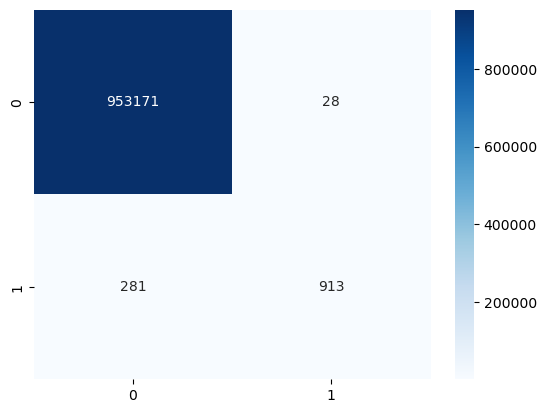

In [51]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues')

Agora conseguimos obter um número melhor, 309 erros dentro os dados disponíveis.

# 4. Validação do Modelo

Iremos transfomar novamente os dados de treino, porém iremos igualar a quantidade de valores para ambas as possibilidades para ver como nosso modelo irá trabalhar em cima desses valores. Treinamos o modelo novamente e realizamos o teste 300 vezes para obter os melhores resultados

In [52]:
rus = RandomUnderSampler(random_state=79)
x_rus, y_rus = rus.fit_resample(x_train, y_train)
print(Counter(y_rus))

Counter({0: 5794, 1: 5794})


In [53]:
cross_acc = []
cross_prec = []
cross_rec = []
for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    acc =cross_val_score(rfcfinal, x_rus, y_rus, cv = kfold).mean()
    prec =cross_val_score(rfcfinal, x_rus, y_rus,cv = kfold, scoring='precision_macro').mean()
    rec = cross_val_score(rfcfinal, x_rus, y_rus,cv = kfold, scoring='recall_macro').mean()
    
    cross_acc.append(acc)
    cross_prec.append(prec)
    cross_rec.append(rec)

In [54]:
results = pd.DataFrame({
    "Accuracy": cross_acc, 
    "Precision": cross_prec,
    "Recall": cross_rec
})
results

,Accuracy,Precision,Recall
0,0.991284,0.991309,0.991326
1,0.991111,0.991170,0.991098
2,0.990852,0.990918,0.990859
3,0.991284,0.991308,0.991328
4,0.991284,0.991331,0.991294
5,0.991111,0.991212,0.991066
6,0.991371,0.991440,0.991344
7,0.991629,0.991685,0.991608
8,0.991716,0.991781,0.991706
9,0.991629,0.991714,0.991585


In [55]:
results.describe()

,Accuracy,Precision,Recall
count,30.000000,30.000000,30.000000
mean,0.991192,0.991254,0.991185
std,0.000327,0.000325,0.000326
min,0.990249,0.990297,0.990264
25%,0.991025,0.991102,0.991002
50%,0.991284,0.991309,0.991267
75%,0.991370,0.991429,0.991380
max,0.991716,0.991781,0.991745


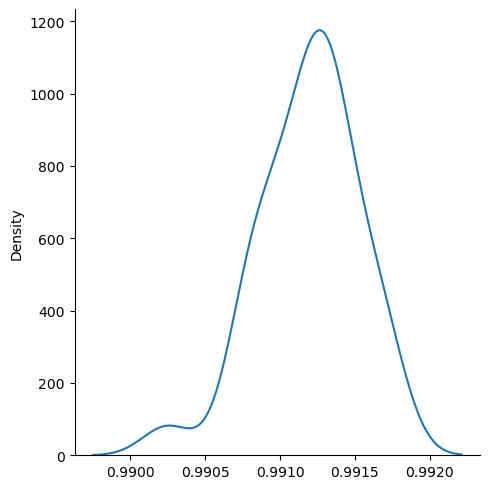

In [56]:
sns.displot(cross_acc, kind="kde")

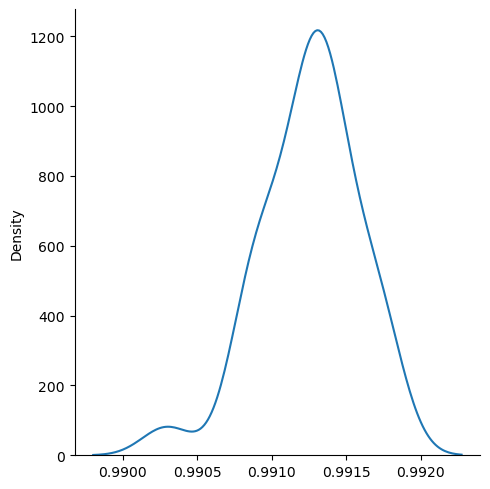

In [57]:
sns.displot(cross_prec, kind="kde")

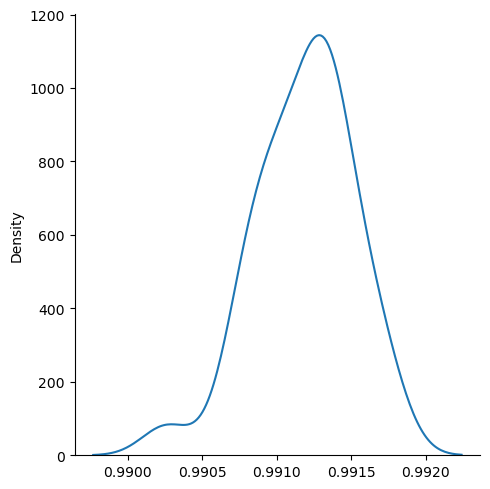

In [58]:
sns.displot(cross_rec, kind="kde")

Dado esses resultados, conseguimos diminuir o resultado e manter uma média para cada classificador o que nos indica que poderemos exportar nosso modelo para área de deploy.

# 5. Deploy do Modelo
Aqui exportamos o modelo para outro arquivo e fazemos lá a transformação necessária para testar antes de exportar para o aplicativo do render, aqui abaixo realizo um teste na minha máquina e depois na API.

## 5.1 Teste na minha Máquina
Para fazer o teste utilizei do arquivo handler.py para fazer uma versão online e testar com a api e o modelo fazer a classificação

In [59]:
# import pickle 
# pickle.dump(rfcfinal, open("./fraud_detection.pkl", 'wb'))

In [70]:
df = dataset.drop('isFraud', axis=1).sample()

In [71]:
df_json = df.to_json(orient='records')

In [72]:
df_json

'[{"step":181,"type":"CASH_IN","amount":32232.46,"nameOrig":"C1707470703","oldbalanceOrg":7047204.79,"newbalanceOrig":7079437.25,"nameDest":"C1977612729","oldbalanceDest":61131.06,"newbalanceDest":28898.6,"isFlaggedFraud":0}]'

In [73]:
header = {"Content-type": "application/json"}

In [64]:
# import requests
# r = requests.post(url="http://10.0.0.107:5000/predict", data=df_json, headers=header)

In [65]:
# r.status_code, r.json()

## 5.2 Teste na API

In [68]:
!python --version
import requests

Python 3.12.0


In [74]:
url = "https://fraud-detection-sde8.onrender.com/predict"
d = requests.post(url=url, data=df_json, headers=header)

In [75]:
d.status_code, d.json()

(200,
 [{'type': 4.0,
   'amount': 32232.46,
   'oldbalanceOrg': 7047204.79,
   'newbalanceOrig': 7079437.25,
   'oldbalanceDest': 61131.06,
   'isFlaggedFraud': 0,
   'hour_class': 0,
   'quanTransf': 1,
   'prediction': 0}])